In [2]:
import tensorflow as tf  
from tensorflow.keras import  models,layers
import matplotlib.pyplot as plt

In [3]:
ImageSize=255
BatchSize=32
Channels=3
Epochs=30


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Faces",
    shuffle=True,
    image_size=(ImageSize,ImageSize),
    batch_size=BatchSize
)

Found 1400 files belonging to 2 classes.


In [5]:
class_names=dataset.class_names
class_names

['Fake image', 'Real image']

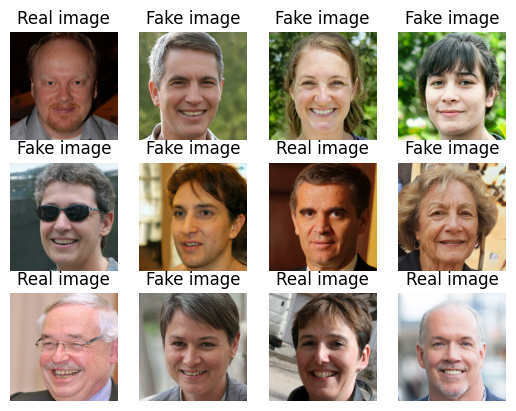

In [6]:

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [7]:
len(dataset)

44

In [8]:
train_size=0.8
len(dataset)*train_size

35.2

In [9]:
train_ds=dataset.take(50)
len(train_ds)

44

In [10]:
test_ds=dataset.skip(50)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

4.4

In [12]:
val_ds=test_ds.take(7)
test_ds=test_ds.skip(7)

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(ImageSize, ImageSize),
  layers.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
input_shape = (BatchSize, ImageSize, ImageSize, Channels)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BatchSize,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs,
)

Epoch 1/30
35/35 [==============================] - 56s 1s/step - loss: 0.6949 - accuracy: 0.4910 - val_loss: 0.6926 - val_accuracy: 0.5469
Epoch 2/30
35/35 [==============================] - 44s 1s/step - loss: 0.6933 - accuracy: 0.5018 - val_loss: 0.6924 - val_accuracy: 0.5469
Epoch 3/30
35/35 [==============================] - 42s 1s/step - loss: 0.6934 - accuracy: 0.5054 - val_loss: 0.6926 - val_accuracy: 0.5469
Epoch 4/30
35/35 [==============================] - 44s 1s/step - loss: 0.6935 - accuracy: 0.5054 - val_loss: 0.6920 - val_accuracy: 0.5469
Epoch 5/30
35/35 [==============================] - 44s 1s/step - loss: 0.6932 - accuracy: 0.4802 - val_loss: 0.6929 - val_accuracy: 0.5469
Epoch 6/30
35/35 [==============================] - 46s 1s/step - loss: 0.6933 - accuracy: 0.4829 - val_loss: 0.6927 - val_accuracy: 0.5469
Epoch 7/30
35/35 [==============================] - 43s 1s/step - loss: 0.6932 - accuracy: 0.5054 - val_loss: 0.6910 - val_accuracy: 0.5469
Epoch 8/30
35/35 [==

In [23]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 9s 340ms/step - loss: 0.6956 - accuracy: 0.3938


In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 35}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

30

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6948997378349304,
 0.6933368444442749,
 0.6933575868606567,
 0.6934748291969299,
 0.6932399272918701]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

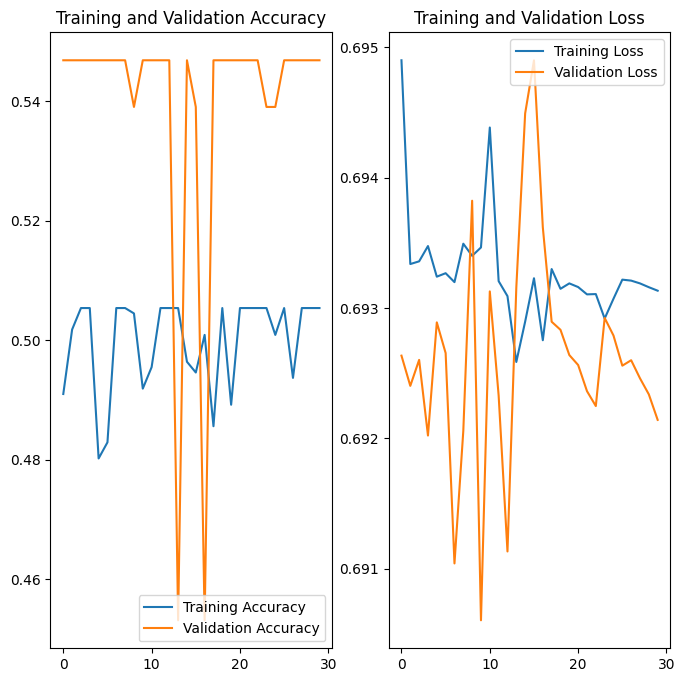

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), loss, label='Training Loss')
plt.plot(range(Epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Fake image
1/1 [==============================] - 1s 623ms/step
predicted label: Real image


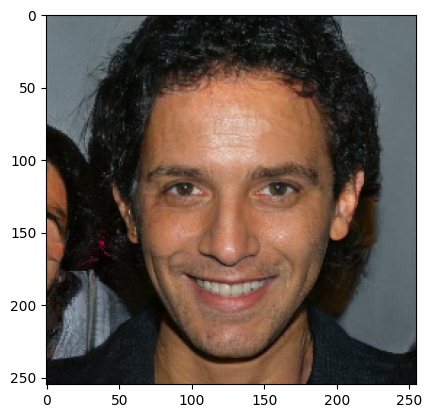

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 52ms/step


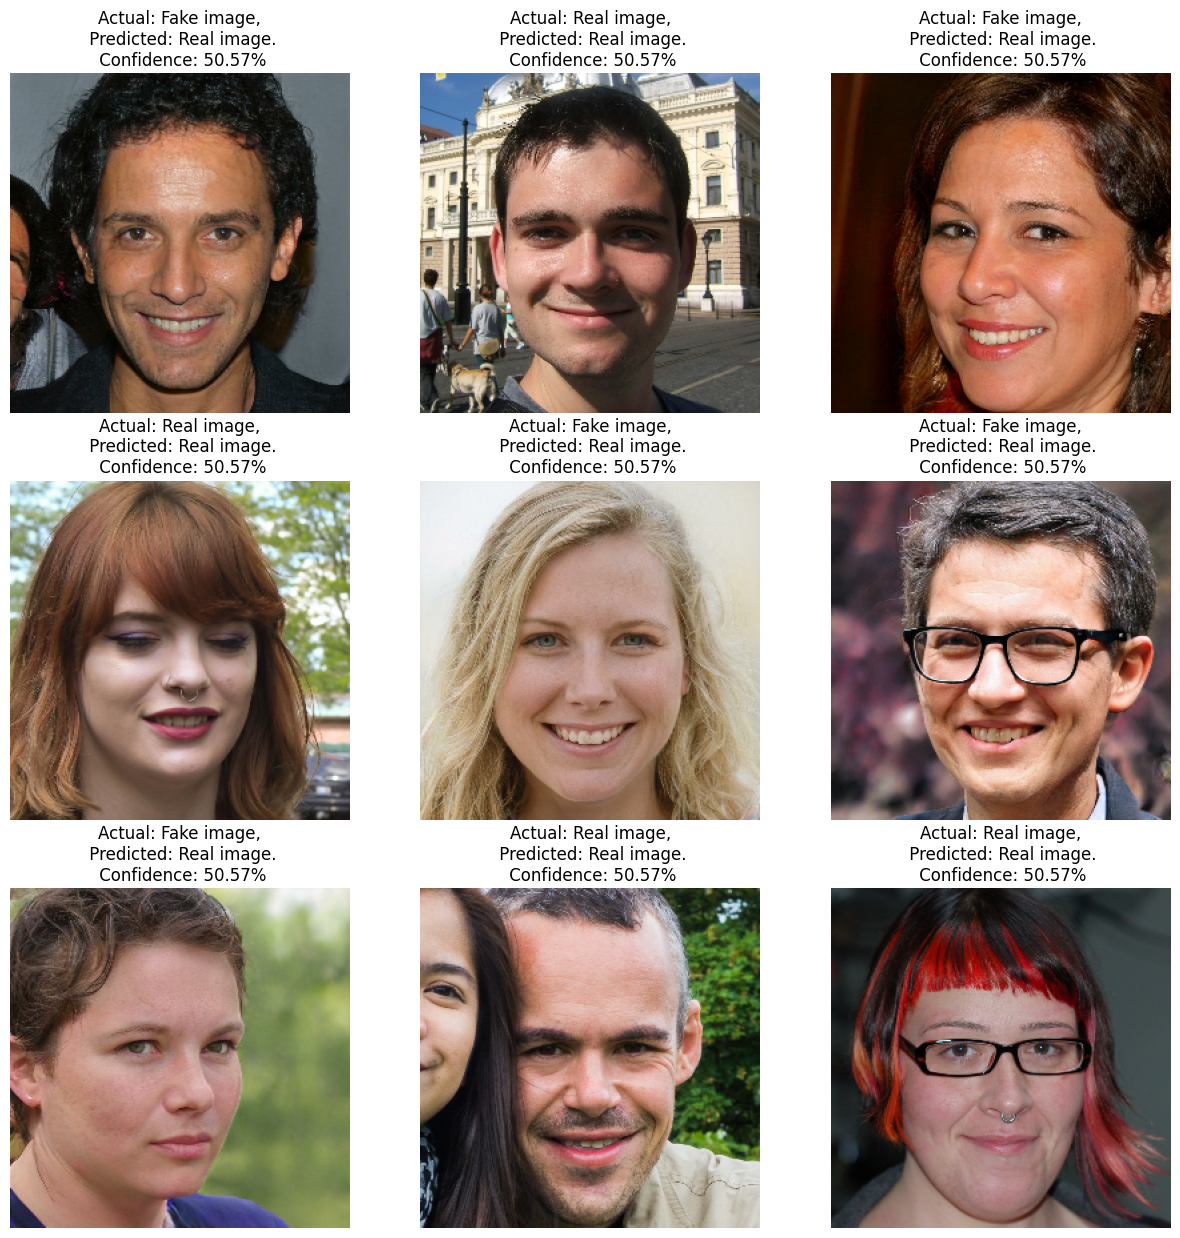

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/12\assets


INFO:tensorflow:Assets written to: ../models/12\assets


In [36]:
model.save("../potatoes.h5")

c:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Function to calculate metrics for a given dataset
def evaluate_metrics(model, dataset):
    y_true = []
    y_pred = []
    y_prob = []

    # Get predictions and true labels from the dataset
    for images_batch, labels_batch in dataset:
        predictions = model.predict(images_batch)
        y_true.extend(labels_batch.numpy())  # True labels
        y_pred.extend(np.argmax(predictions, axis=1))  # Predicted classes
        
        # For AUC, obtain probabilities for the positive class (class 1)
        y_prob.extend(predictions[:, 1])  # Assuming the positive class is at index 1

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_prob)

    return accuracy, precision, recall, f1, auc

# Evaluate on the Training dataset
train_accuracy, train_precision, train_recall, train_f1, train_auc = evaluate_metrics(model, train_ds)
print("Training Dataset Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"AUC: {train_auc:.4f}")
print()

# Evaluate on the Validation dataset
val_accuracy, val_precision, val_recall, val_f1, val_auc = evaluate_metrics(model, val_ds)
print("Validation Dataset Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print(f"AUC: {val_auc:.4f}")


1/1 [==============================] - 0s 341ms/step
Training Dataset Metrics:
Accuracy: 0.5054
Precision: 0.5054
Recall: 1.0000
F1-Score: 0.6714
AUC: 0.5359

1/1 [==============================] - 0s 353ms/step
Validation Dataset Metrics:
Accuracy: 0.5469
Precision: 0.5469
Recall: 1.0000
F1-Score: 0.7071
AUC: 0.4243
